# Review Experiment Results

In [1]:
%matplotlib inline
from pathlib import Path
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus
from gensim.test.utils import datapath
from gensim.corpora.dictionary import Dictionary
from scipy import sparse
import pyLDAvis
from pyLDAvis.gensim import prepare
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import graphviz 
import pydotplus
from IPython.display import Image

In [2]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [3]:
percentiles=np.arange(.1, 1, .1).round(1)

In [130]:
experiment_path = Path('experiments_06')

## View coherence summary

In [132]:
results = pd.read_csv(experiment_path / 'coherence.csv').fillna(75000).sort_values('u_mass', ascending=False)
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 3 to 0
Data columns (total 6 columns):
vocab_size      4 non-null int64
test_vocab      4 non-null int64
max_features    4 non-null float64
n_topics        4 non-null int64
perplexity      4 non-null float64
u_mass          4 non-null float64
dtypes: float64(3), int64(3)
memory usage: 224.0 bytes


### Best Models for each n_topics

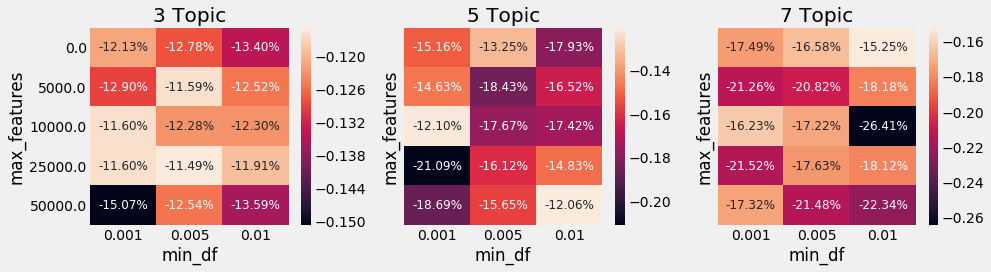

In [48]:
fig, axes=plt.subplots(figsize=(14,4), ncols=3, sharex=True, sharey=True)
for i, n in enumerate([3, 5, 7]):
    sns.heatmap(data=coherence_by_ntopics.loc[n], annot=True, fmt='.2%', ax=axes[i], annot_kws={"size": 12})
    axes[i].set_title(f'{n} Topic')
# sns.heatmap(data=coherence_by_ntopics.loc[3], annot=True, fmt='.2%', ax=axes[0])
# sns.heatmap(data=coherence_by_ntopics.loc[3], annot=True, fmt='.2%', ax=axes[0])
fig.tight_layout();

In [ ]:
results.max_features = results.max_features.astype(int)
results = results.rename(columns={'coherence': 'UMass Score', 'min_df': 'Min. Document Frequency', 'max_features': 'Max. # Features'})

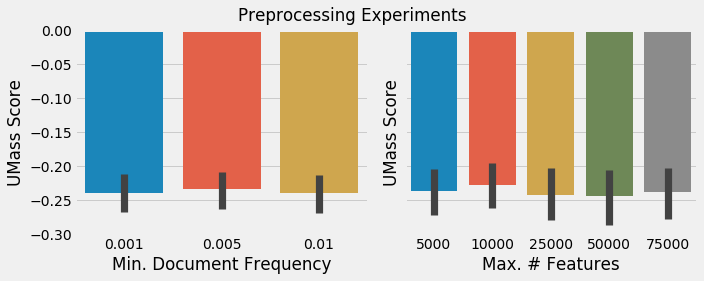

In [124]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,4), sharey=True)
axes = axes.flatten()
features = ['Min. Document Frequency', 'Max. # Features']
for i, feature in enumerate(features):
    sns.barplot(x=feature, y='UMass Score', data=results, ax=axes[i])
fig.suptitle('Preprocessing Experiments')
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig('preprocessing', dpi=300);

In [15]:
reg_tree = DecisionTreeRegressor()
reg_tree.fit(y=results.coherence, X=results[features])

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

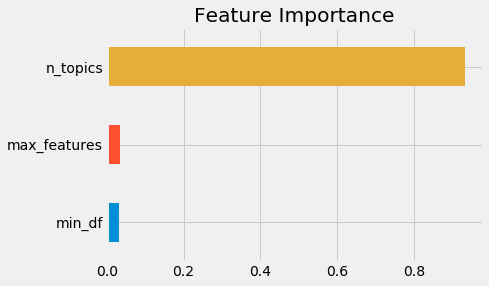

In [16]:
pd.Series(reg_tree.feature_importances_, index=features).sort_values().plot.barh(title='Feature Importance');

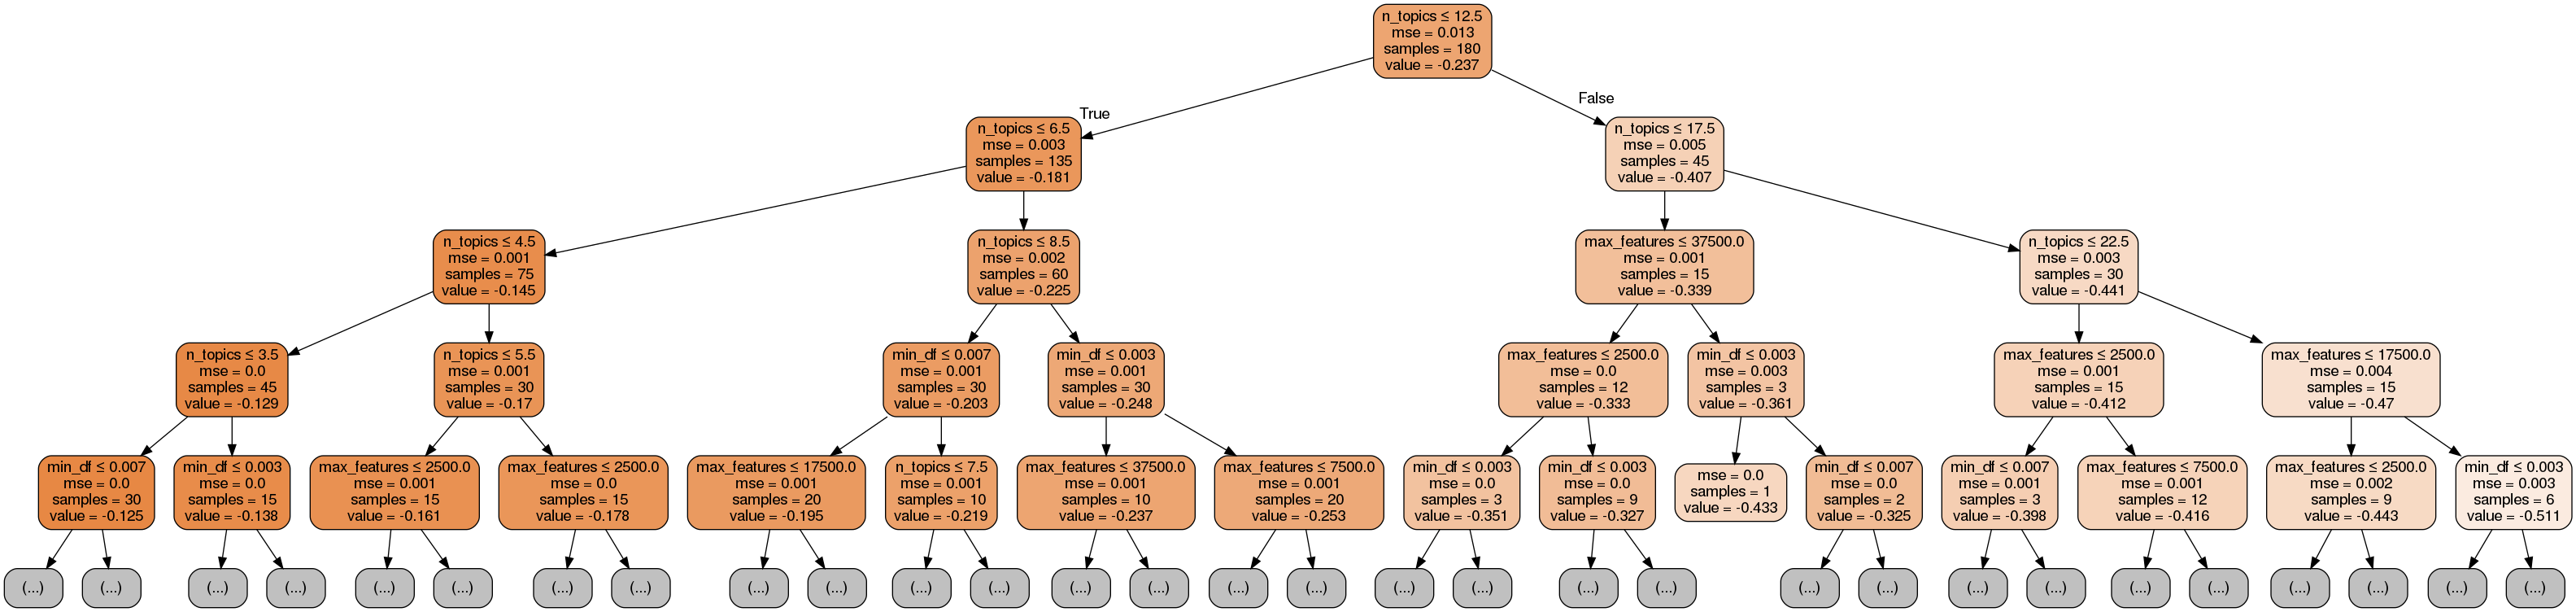

In [17]:
dot_data = export_graphviz(reg_tree, 
                           max_depth=4,
                           feature_names=features,  
                           filled=True, 
                           rounded=True,  
                           special_characters=True,
                           out_file=None)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
Image(pydot_graph.create_png())

## Select Experiment

In [173]:
min_df = .001 # [.001, .01, .025, .05]
# max_df = .9  # [.1, .25, .5, .75, .9]
binary = False # [True, False]
n_topics = 20 # [2-10, 15, 20, 25]
max_features = None

In [174]:
# key = f'{int(min_df*1000):,d}_{int(max_df*1000):,d}_{int(binary)}'
key = f'{max_features if max_features is not None else 0:d}'
topic_labels = [f'Topic {i}' for i in range(1, n_topics + 1)]

## Load Corpus

In [175]:
corpus_path = experiment_path / 'corpora'

In [176]:
dtm_path = corpus_path / f'dtm_{key}.npz'
dtm = sparse.load_npz(dtm_path)

In [177]:
token_path = corpus_path / f'tokens_{key}.csv'
tokens = pd.read_csv(token_path, header=None, squeeze=True, na_values=[], keep_default_na=False)

## Load Model

In [178]:
cwd = Path().cwd()
model_file = datapath((experiment_path / 'models' / f'{key}_{n_topics}').resolve())
lda_model = LdaModel.load(model_file)

## Create gensim data structures

In [179]:
id2word = tokens.to_dict()
corpus = Sparse2Corpus(dtm, documents_columns=False)
dictionary = Dictionary.from_corpus(corpus, id2word)

## PyLDAVis

In [180]:
vis = prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

### Show topics

In [13]:
topic_words = pd.DataFrame()
topic_probs = pd.DataFrame()
for topic in range(n_topics):
    terms = lda_model.get_topic_terms(topic)
    top_words = pd.DataFrame(terms, columns=['term', 'probability'])
    topic_words[topic_labels[topic]] = top_words.term.map(id2word)
    topic_probs[topic_labels[topic]] = top_words.probability
topic_words.T

,0,1,2,3,4,5,6,7,8,9
Topic 1,signal,processing,noise,reconstruction,image,algorithm,matrix,index,method,pattern
Topic 2,acm,journal,conference,international,proceeding,systems,springer,transactions,eferences,symposium
Topic 3,training,train,note,distribution,term,introduction,set,different,abstract,contrast
Topic 4,norm,matrix,theorem,vector,convex,linear,let,proof,dimensional,value
Topic 5,plot,simulation,independent,random,simple,size,approximate,remain,distribution,density
Topic 6,definition,proof,theorem,let,hold,imply,satisfy,prove,following,property
Topic 7,implement,core,execution,implementation,create,code,operation,execute,example,run
Topic 8,social,people,study,high,world,list,consider,provide,research,example
Topic 9,demonstrate,describe,mean,model,train,table,figure,consider,processing,follow
Topic 10,classification,training,classifier,train,test,number,learn,abstract,experiment,table


In [14]:
# can maybe transfer style from probabilities to terms
cm = sns.light_palette("green", as_cmap=True)
topic_probs.T.style.background_gradient(cmap=cm).format('{:,.2%}'.format)

,0,1,2,3,4,5,6,7,8,9
Topic 1,0.22%,0.18%,0.17%,0.16%,0.16%,0.16%,0.16%,0.15%,0.15%,0.15%
Topic 2,0.32%,0.31%,0.30%,0.30%,0.26%,0.26%,0.25%,0.25%,0.23%,0.22%
Topic 3,0.19%,0.19%,0.18%,0.18%,0.18%,0.18%,0.17%,0.17%,0.17%,0.17%
Topic 4,0.23%,0.21%,0.20%,0.20%,0.19%,0.19%,0.19%,0.19%,0.18%,0.18%
Topic 5,0.16%,0.15%,0.15%,0.14%,0.14%,0.14%,0.14%,0.14%,0.13%,0.13%
Topic 6,0.20%,0.20%,0.19%,0.19%,0.18%,0.17%,0.17%,0.17%,0.17%,0.17%
Topic 7,0.21%,0.20%,0.19%,0.19%,0.18%,0.18%,0.17%,0.17%,0.17%,0.17%
Topic 8,0.18%,0.15%,0.13%,0.13%,0.13%,0.13%,0.13%,0.13%,0.13%,0.12%
Topic 9,0.18%,0.15%,0.15%,0.14%,0.14%,0.14%,0.14%,0.14%,0.14%,0.14%
Topic 10,0.28%,0.28%,0.28%,0.27%,0.26%,0.26%,0.26%,0.25%,0.25%,0.25%


In [111]:
lda_model.print_topics()

[(0,
  '0.002*"function" + 0.001*"estimate" + 0.001*"dynamic" + 0.001*"model" + 0.001*"stochastic" + 0.001*"distribution" + 0.001*"base" + 0.001*"set" + 0.001*"parameter" + 0.001*"figure"'),
 (1,
  '0.002*"introduction" + 0.002*"abstract" + 0.002*"image" + 0.002*"method" + 0.002*"high" + 0.002*"different" + 0.002*"include" + 0.002*"compare" + 0.002*"evaluate" + 0.002*"experiment"'),
 (2,
  '0.002*"image" + 0.002*"processing" + 0.001*"pixel" + 0.001*"pattern" + 0.001*"vision" + 0.001*"computer" + 0.001*"base" + 0.001*"algorithm" + 0.001*"application" + 0.001*"eferences"'),
 (3,
  '0.002*"let" + 0.002*"theorem" + 0.002*"proof" + 0.002*"denote" + 0.002*"define" + 0.002*"consider" + 0.002*"case" + 0.002*"result" + 0.002*"follow" + 0.002*"assume"'),
 (4,
  '0.002*"data" + 0.002*"test" + 0.002*"good" + 0.002*"performance" + 0.002*"high" + 0.002*"compare" + 0.002*"mean" + 0.002*"datum" + 0.002*"feature" + 0.002*"measure"'),
 (5,
  '0.001*"possible" + 0.001*"number" + 0.001*"case" + 0.001*"exa

### Show topic coherence

In [77]:
coherence = lda_model.top_topics(corpus=corpus, coherence='u_mass', topn=n_topics)

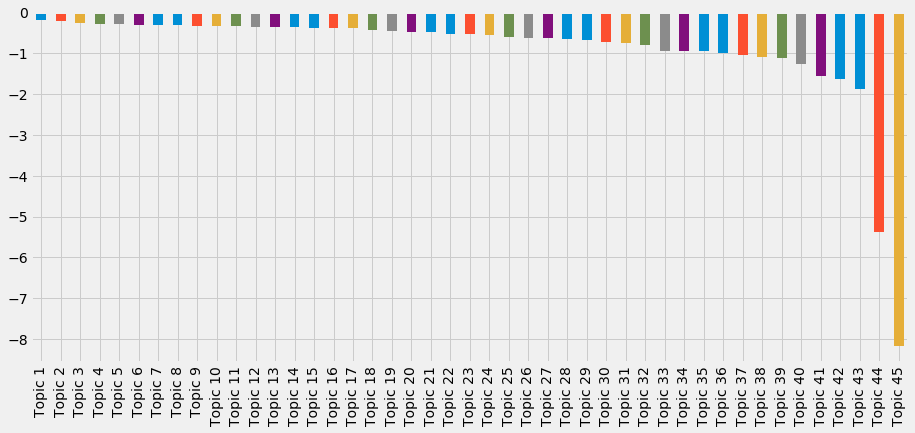

In [78]:
topic_coherence  = []
topic_words = pd.DataFrame()
for t in range(len(coherence)):
    label = topic_labels[t]
    topic_coherence.append(coherence[t][1])
    df = pd.DataFrame(coherence[t][0], columns=[(label, 'prob'), (label, 'term')])
    df[(label, 'prob')] = df[(label, 'prob')].apply(lambda x: '{:.2%}'.format(x))
    topic_words = pd.concat([topic_words, df], axis=1)
                      
topic_words.columns = pd.MultiIndex.from_tuples(topic_words.columns)
pd.set_option('expand_frame_repr', False)
# print(topic_words.head())
pd.Series(topic_coherence, index=topic_labels).plot.bar(figsize=(14,6));

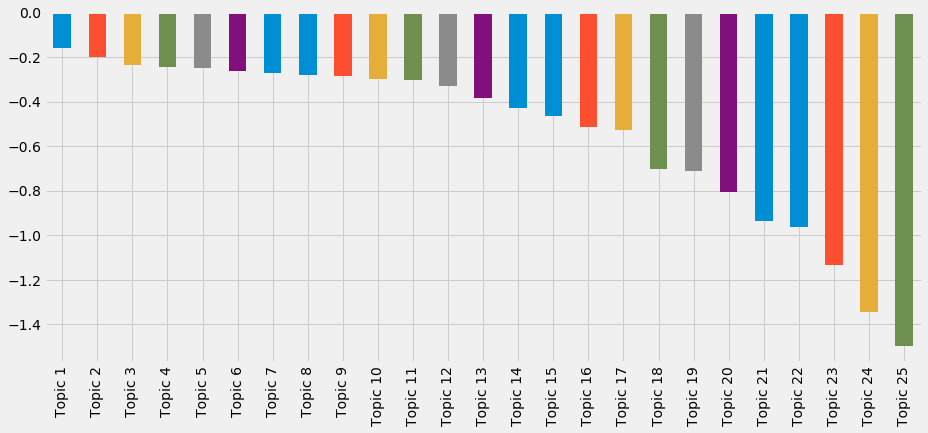

In [70]:
topic_coherence  = []
topic_words = pd.DataFrame()
for t in range(len(coherence)):
    label = topic_labels[t]
    topic_coherence.append(coherence[t][1])
    df = pd.DataFrame(coherence[t][0], columns=[(label, 'prob'), (label, 'term')])
    df[(label, 'prob')] = df[(label, 'prob')].apply(lambda x: '{:.2%}'.format(x))
    topic_words = pd.concat([topic_words, df], axis=1)
                      
topic_words.columns = pd.MultiIndex.from_tuples(topic_words.columns)
pd.set_option('expand_frame_repr', False)
# print(topic_words.head())
pd.Series(topic_coherence, index=topic_labels).plot.bar(figsize=(14,6));

## Get topic distribution by document

In [114]:
text_path = Path('../data/clean_stop')
text_files = text_path.glob('*.txt')
docs = [f.read_text() for f in text_files]
len(docs)

26717

In [115]:
bow = dictionary.doc2bow(docs[5].split())
lda_model.get_document_topics(bow=bow, minimum_probability=1e-3)

NameError: name 'dictionary' is not defined

In [ ]:
document_topics = pd.DataFrame(index=topic_labels)
for i, doc in enumerate(docs):
    bow = dictionary.doc2bow(doc.split())
    document_topics[i] = pd.Series({f'Topic {k+1}':v for k, v in lda_model.get_document_topics(bow=bow, minimum_probability=1e-3)})
document_topics = document_topics.T
document_topics.info()

In [ ]:
topics_stacked = document_topics.stack().reset_index(0, drop=True).reset_index()
topics_stacked.columns = ['Topic', 'Probability']

In [ ]:
ax = sns.boxenplot(x='Topic',y='Probability', data=topics_stacked)
ax.set_title('Topic Probability Distribution');

In [ ]:
document_topics.count(1).value_counts().sort_index().plot.bar(title='# Topics per Document');

## Topic Sentences

In [42]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=docs)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.5744,"level, study, pattern, research, human, create...",neural network coordination boundary predictio...
1,1,0.0,0.6234,"image, pixel, fig, computer, vision, compariso...",environmental noise embeddings for robust spee...
2,2,3.0,0.5710,"training, train, distribution, network, gradie...",journal latex class files vol august the chann...
3,3,3.0,0.3576,"training, train, distribution, network, gradie...",target orient high resolution sar image format...
4,4,3.0,0.4348,"training, train, distribution, network, gradie...",dnn base speech synthesis indian languages asc...
5,5,0.0,0.6088,"image, pixel, fig, computer, vision, compariso...",multiple instance detection network online ins...
6,6,2.0,0.5312,"level, study, pattern, research, human, create...",additive approximations high dimensional nonpa...
7,7,4.0,0.9444,"let, assume, definition, know, general, denote...",knowledge elicitation sequential probabilistic...
8,8,1.0,0.8325,"train, training, task, network, neural, datase...",threshold constraints guarantees parity object...
9,9,4.0,0.9651,"let, assume, definition, know, general, denote...",oct almost optimal algorithms linear stochasti...


In [43]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(20)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9990,"image, pixel, fig, computer, vision, compariso...",towards collaborative conceptual exploration t...
1,1.0,0.9992,"train, training, task, network, neural, datase...",NaN
2,2.0,0.9992,"level, study, pattern, research, human, create...",NaN
3,3.0,0.9987,"training, train, distribution, network, gradie...",NaN
4,4.0,0.9992,"let, assume, definition, know, general, denote...",barzilai borwein step size stochastic gradient...
